In [1]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import statistics
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

Using TensorFlow backend.


In [2]:
sms = pd.read_csv("sms.csv", encoding = "latin-1")
sms = sms[['RESULT', 'SMS']]
sms = sms.rename(columns = {'RESULT': 'label', 'SMS': 'text'})

In [3]:
sms.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms['label'].value_counts()

ham     4800
spam     740
Name: label, dtype: int64

In [5]:
sms_nonLabelled = sms[sms['label'].isna()]

In [6]:
sms.dropna(inplace = True)

### DATA CLEANING AND PROCESSING

In [7]:
def normalize(text):
    return text.lower()

In [8]:
sms['text'] = sms['text'].apply(normalize)
sms.head()

,label,text
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [9]:
model = "en_core_web_sm"
nlp = spacy.load(model)

In [10]:
def text_processing(text):
    all_stopwords = nlp.Defaults.stop_words
    text = nlp(text)
    text_tokens = [token.lemma_ for token in text]
    tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
    return " ".join(tokens_without_sw)

In [11]:
sms['text'] = sms['text'].apply(text_processing)
sms.head()

,label,text
0,ham,"jurong point , crazy .. available bugis n grea..."
1,ham,ok lar ... joke wif u oni ...
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun early hor ... u c ...
4,ham,"nah think -PRON- usf , -PRON- live"


### TRAINING AND EVALUATING MODELS

In [12]:
data_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, test_index in data_split.split(sms, sms['label']):
    sms_train = sms.iloc[train_index]
    sms_test = sms.iloc[test_index]
print(len(sms_train), 'Train data, ', len(sms_test), 'Test data.')

3878 Train data,  1662 Test data.


In [13]:
sms_train.reset_index(inplace = True)
sms_train.drop(columns=['index'], inplace = True)
sms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3878 entries, 0 to 3877
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3878 non-null   object
 1   text    3878 non-null   object
dtypes: object(2)
memory usage: 60.7+ KB


c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
sms_test.reset_index(inplace = True)
sms_test.drop(columns=['index'], inplace = True)
sms_test.info()
#Now we will not use our sms_test till our model is finalized.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662 entries, 0 to 1661
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1662 non-null   object
 1   text    1662 non-null   object
dtypes: object(2)
memory usage: 26.1+ KB


In [15]:
y = sms_train['label'].copy().to_list()
X = sms_train['text'].copy().to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [16]:
model_comparision = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

#### K-NN Algorithm

In [17]:
# Creating odd list K for KNN
neighbors = list(range(1,50,2))
# empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn,X,y,cv = 10,scoring =
    "accuracy")
    cv_scores.append(scores.mean())

In [18]:
# Changing to mse classification error
mse = [1-x for x in cv_scores]
# determing best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

The optimal no. of neighbors is 1


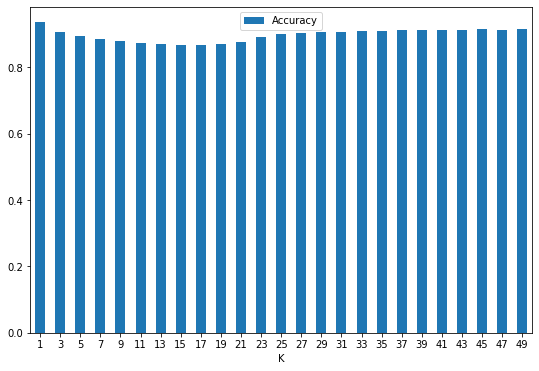

In [19]:
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,50,2)], "Accuracy":knn_list_scores}).set_index("K").plot.bar(figsize= (9,6),rot=0)
    plt.show()
plot_accuracy(cv_scores)

In [20]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
train_predicted = cross_val_predict(knn_clf, X, y, cv=3)
conf_mx = confusion_matrix(y, train_predicted)

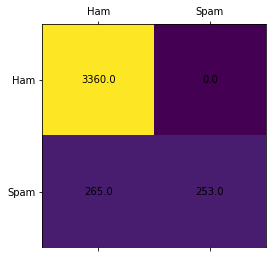

In [21]:
plt.matshow(conf_mx)
alpha = ['Ham', 'Spam']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [22]:
def get_accuracy(mat):
    acc = 0
    tot = 0
    for i in range(2):
        for j in range(2):
            tot += mat[i][j]
            if i == j:
                acc += mat[i][j]
    return acc/tot

In [23]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y, train_predicted, average="macro")
recall = recall_score(y, train_predicted, average="macro")
f1 = f1_score(y, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'KNN', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

#### SGD Classifier without Over-Sampling

In [24]:
sgd_clf = SGDClassifier(random_state = 42)
train_predicted = cross_val_predict(sgd_clf, X, y, cv=3)
conf_mx = confusion_matrix(y, train_predicted)

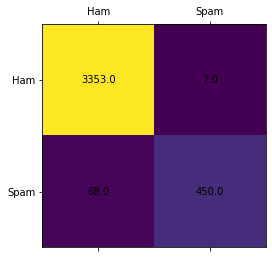

In [25]:
plt.matshow(conf_mx)
alpha = ['Ham', 'Spam']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [26]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y, train_predicted, average="macro")
recall = recall_score(y, train_predicted, average="macro")
f1 = f1_score(y, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SGD W/O Oversampling', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

In [27]:
sms_train['label'].value_counts()
# We have to oversample the imbalanced dataset to get some better results

ham     3360
spam     518
Name: label, dtype: int64

#### OVER-SAMPLING ON IMBALANCED DATASET

In [28]:
smote = SMOTE('minority')
X_os, y_os = smote.fit_sample(X, y)

#### SGD Classifier

In [29]:
train_predicted = cross_val_predict(sgd_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

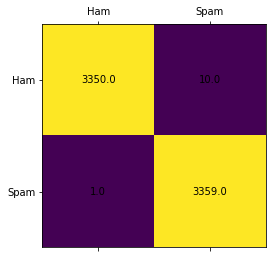

In [30]:
plt.matshow(conf_mx)
alpha = ['Ham', 'Spam']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [31]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SGD', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

#### Random Forest

In [32]:
forest_clf = RandomForestClassifier(random_state = 42)
train_predicted = cross_val_predict(forest_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

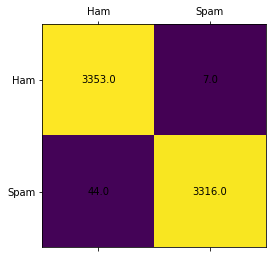

In [33]:
plt.matshow(conf_mx)
alpha = ['Ham', 'Spam']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [34]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'Random Forest', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

#### SVM Classifier - Support Vector Classification

In [35]:
svm_clf = svm.SVC(random_state = 42)
train_predicted = cross_val_predict(svm_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

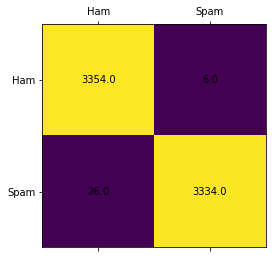

In [36]:
plt.matshow(conf_mx)
alpha = ['Ham', 'Spam']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [37]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SVM (SVC)', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

In [38]:
svm_clf = svm.LinearSVC(random_state = 42, max_iter = 10000)
train_predicted = cross_val_predict(svm_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

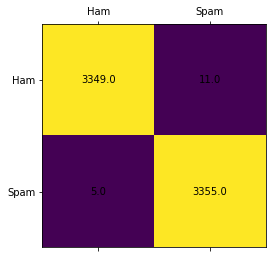

In [39]:
plt.matshow(conf_mx)
alpha = ['Ham', 'Spam']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [40]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SVM (Linear SVC)', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

In [41]:
model_comparision.sort_values(by=['F1'], inplace = True)
model_comparision

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.931666,0.963448,0.744208,0.809176
1,SGD W/O Oversampling,0.980660,0.982403,0.933321,0.956008
3,Random Forest,0.992411,0.992470,0.992411,0.992410
4,SVM (SVC),0.995238,0.995256,0.995238,0.995238
5,SVM (Linear SVC),0.997619,0.997621,0.997619,0.997619
2,SGD,0.998363,0.998367,0.998363,0.998363


### EVALUATION ON TEST DATA

In [42]:
# Looking at the above table we should choose SGD Classifier as our final model.
sgd_clf.fit(X_os, y_os)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
y = sms_test['label'].copy().to_list()
X = sms_test['text'].copy().to_list()
X = vectorizer.transform(X)

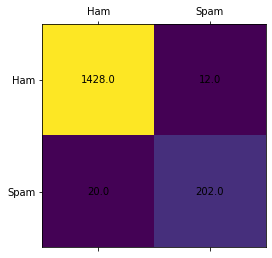

In [44]:
predict = sgd_clf.predict(X)
conf_mx = confusion_matrix(y, predict)
plt.matshow(conf_mx)
alpha = ['Ham', 'Spam']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [45]:
print('Accuarcy -', get_accuracy(conf_mx))
print('Precision -', precision_score(y, predict, average="macro"))
print('recall -', recall_score(y, predict, average="macro"))
print('f1 -', f1_score(y, predict, average="macro"))

Accuarcy - 0.9807460890493381
Precision - 0.9650565394743635
recall - 0.9507882882882883
f1 - 0.9577625860885918


### PREDICTION FOR NON-LABELLED DATA

In [46]:
X = sms_nonLabelled['text'].copy().to_list()
X = [text_processing(normalize(text)) for text in X]
X = vectorizer.transform(X)

In [47]:
predict = list(sgd_clf.predict(X))

In [48]:
output = pd.DataFrame({'SMS':sms_nonLabelled['text'].to_list(), 'RESULT':predict})
output.to_csv('NLP_output.csv')